In [1]:
from qiskit import QuantumCircuit,Aer,transpile, assemble,BasicAer,execute,IBMQ
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
import math

Input maximum 3 digit secret number: 010


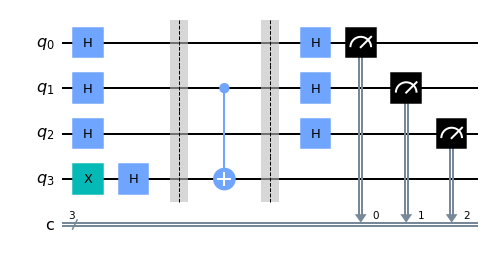

{'010': 8000}


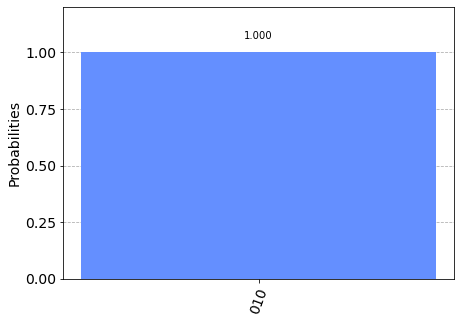

In [2]:
#secret number
try:
    secretnumber = int(input("Input maximum 3 digit secret number: ") , 2)
    secretnumber = [int(i) for i in bin(secretnumber)[2:].zfill(3)]
    secretnumber = secretnumber[::-1]
except ValueError:
    print("Please input only binary value: ")

#1 ancilla
n = len(secretnumber)
qc=QuantumCircuit(n+1,n)
qc.x(n)
for i in range (n+1):
    qc.h(i)
qc.barrier()
for i in range (n):
    if secretnumber[i] == 1:
        qc.cx(i,n)
qc.barrier()
for i in range (n):
    qc.h(i)
# Measurement
for i in range(n):
    qc.measure(i, i)
display(qc.draw('mpl'))

def noise(qc):
    #noise
    qc.u3(1.14,0,0,0)
    qc.h(2)
    qc.cx(0,2)
    qc.h(2)
    qc.cx(0,2)
    qc.barrier()
    #noise finish

#simulator
simulator = Aer.get_backend('qasm_simulator')
simulator_result = execute(qc, backend = simulator, shots = 8000).result()
simulator_counts = simulator_result.get_counts()
print(simulator_counts)
plot_histogram(simulator_counts)

C:\Users\prath\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_lima
6090e26254112334af3f0823
Job Status: job has successfully run
{'000': 457, '001': 7, '010': 7347, '011': 80, '100': 9, '110': 99, '111': 1}


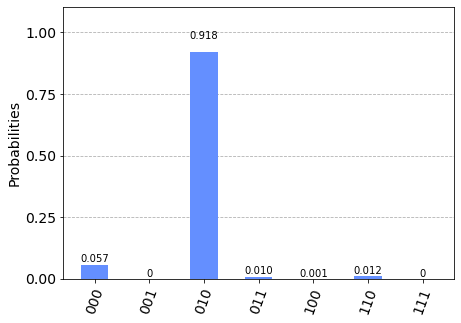

In [3]:
#real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
#Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_qc = transpile(qc, backend = backend)
qobj = assemble(transpiled_qc, shots=8000)
job = backend.run(qobj)
print(job.job_id())
job_monitor(job, interval=2)
real_result = job.result()
real_counts = real_result.get_counts()
print(real_counts)
plot_histogram(real_counts)

<ipython-input-4-4849cccc3072>:15: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qct.u3(0,0,0,i)


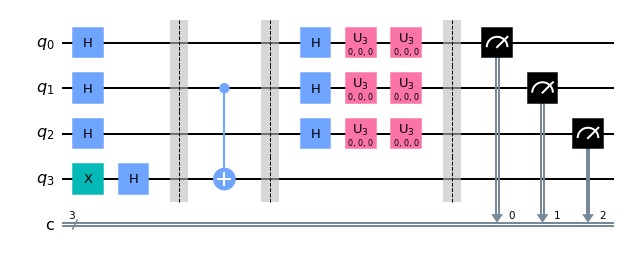

6090e2756cc8285c9e2d8191
Job Status: job has successfully run
{'000': 474, '001': 5, '010': 7356, '011': 74, '100': 6, '101': 1, '110': 84}


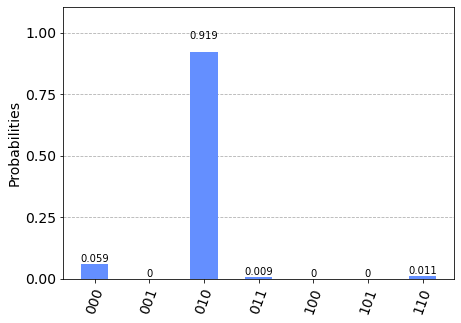

In [4]:
qct=QuantumCircuit(n+1,n)
qct.x(n)
for i in range (n+1):
    qct.h(i)
qct.barrier()
for i in range (n):
    if secretnumber[i] == 1:
        qct.cx(i,n)
qct.barrier()
for i in range (n):
    qct.h(i)
    
#pre-pro
for i in range(n):
    qct.u3(0,0,0,i)
        
for i in range(n):
    qct.u3(0,0,0,i)
qct.barrier()
#pre-pro finish

# Measurement
for i in range(n):
    qct.measure(i, i)
display(qct.draw('mpl'))


transpiled_qct = transpile(qct, backend = backend)
tqobj = assemble(transpiled_qct, shots=8000)
twirl_job = backend.run(tqobj)
print(twirl_job.job_id())
job_monitor(job, interval=2)
twirl_result = twirl_job.result()
twirl_counts = twirl_result.get_counts()
print(twirl_counts)
plot_histogram(twirl_counts)

In [5]:
qubit_list=[0,1,2]
twirl_cal_circuits, twirl_state_labels = complete_meas_cal(qubit_list=qubit_list,qr = qct.qregs[0],circlabel='tcal')
twirl_cal_job = execute(twirl_cal_circuits, backend = backend, shots=8000, optimization_level = 0)
print(twirl_cal_job.job_id())
job_monitor(twirl_cal_job, interval=2)
twirl_cal_results = twirl_cal_job.result()
twirl_meas_fitter = CompleteMeasFitter(twirl_cal_results, twirl_state_labels,circlabel='tcal')
twirl_meas_filter = twirl_meas_fitter.filter

6090e286e742b511604e9953
Job Status: job has successfully run


In [6]:
twirl_mitigated_result = twirl_meas_filter.apply(twirl_result)
twirl_mitigated_counts = twirl_mitigated_result.get_counts(0)

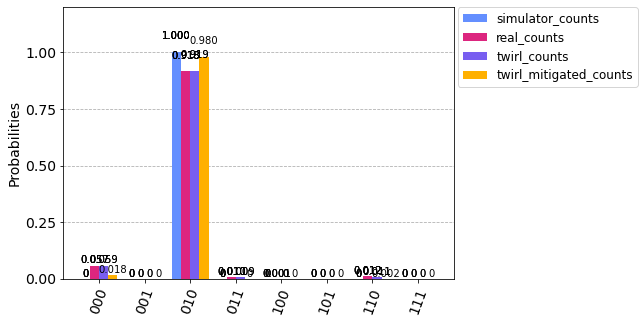

In [7]:
plot_histogram([simulator_counts,real_counts,twirl_counts,twirl_mitigated_counts], legend =['simulator_counts','real_counts','twirl_counts','twirl_mitigated_counts'])

In [8]:
real_mitigated_result = twirl_meas_filter.apply(real_result)
real_mitigated_counts = real_mitigated_result.get_counts(0)

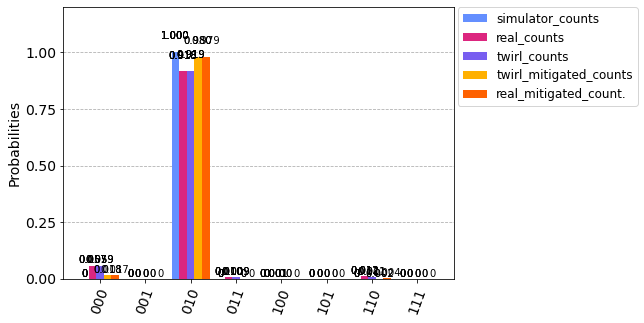

In [9]:
plot_histogram([simulator_counts,real_counts,twirl_counts,twirl_mitigated_counts,real_mitigated_counts], legend =['simulator_counts','real_counts','twirl_counts','twirl_mitigated_counts','real_mitigated_count.'])